In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
np.random.seed(1234)

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV,KFold

In [2]:
# # use GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## File processing

In [3]:
directory = "../CNN/Dataset for CA1 part A/"

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
# Load train data
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/train',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# Load validation data
validation_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/validation',
                                                                 shuffle=True,    
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Load test data
test_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/test',
                                                                 shuffle=True,    
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)                                                                 

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [5]:
# List vegetable classes
class_names = train_dataset.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [6]:
# Print total no. of training batches
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())

Number of training batches: 283


## EDA

In [7]:
# Split datasets 
X_train = []
y_train = []

for images, labels in train_dataset:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train) 

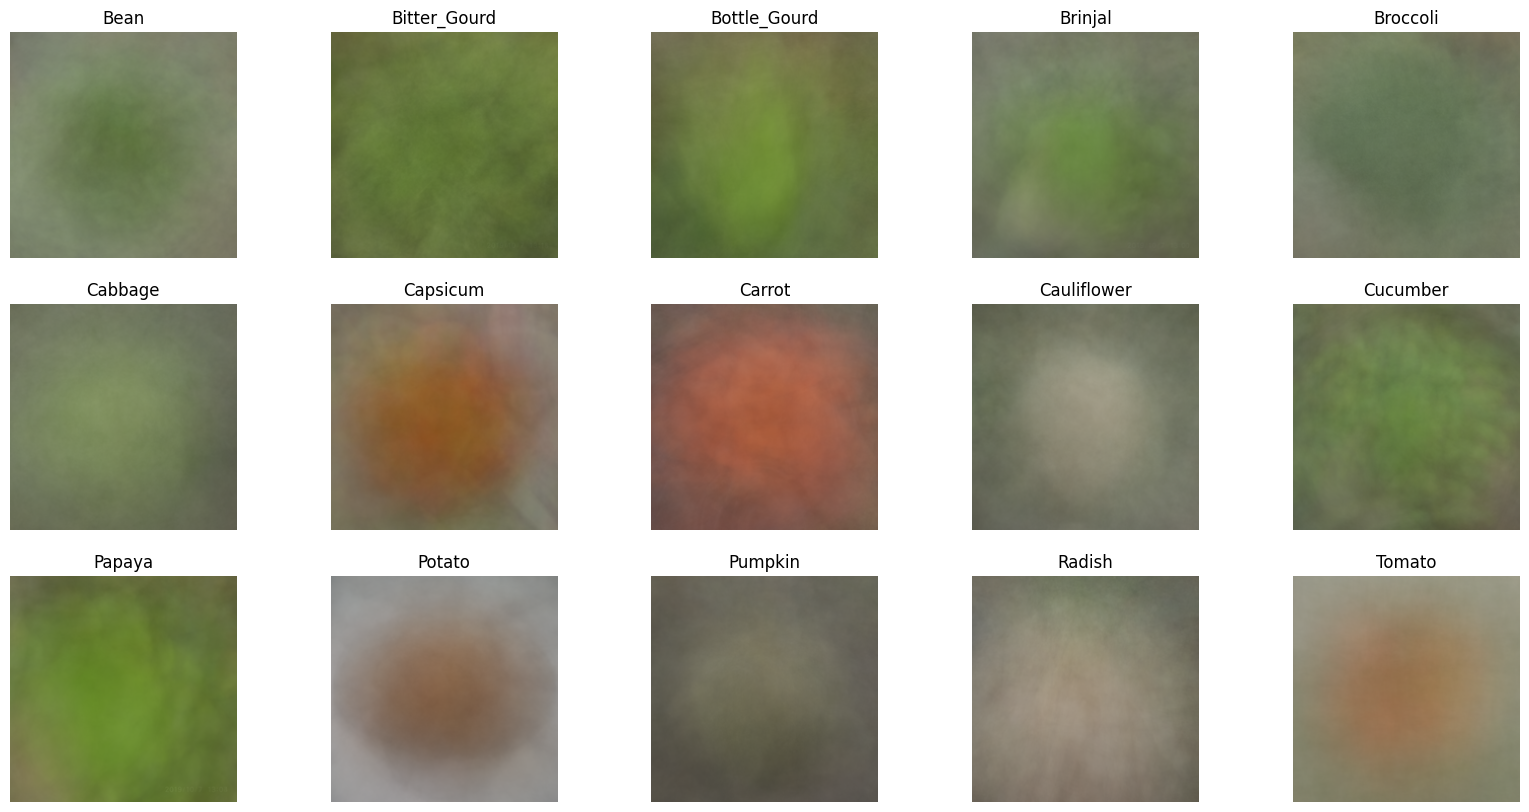

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5, figsize=(20, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(X_train[np.squeeze(y_train == idx)], axis=0) / 255
    subplot.imshow(avg_image, cmap="Greys")
    subplot.set_title(f"{class_names[idx]}")
    subplot.axis("off")

In [9]:
# Find value counts
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

Bean: 780
Bitter_Gourd: 720
Bottle_Gourd: 441
Brinjal: 868
Broccoli: 750
Cabbage: 503
Capsicum: 351
Carrot: 256
Cauliflower: 587
Cucumber: 812
Papaya: 566
Potato: 377
Pumpkin: 814
Radish: 248
Tomato: 955


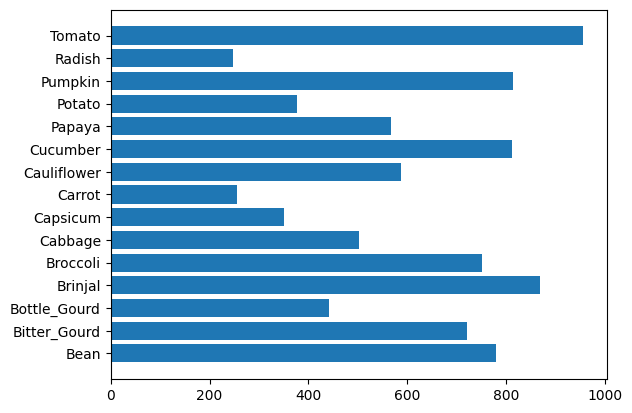

In [10]:
# Plot value counts
plt.barh(labels, counts, tick_label=list(class_names))
plt.show()


Radishes, Potatoes, Carrots, Capsicums, Cabbages, Papayas and Bottle Gourds are especially undersampled, perform augmentation to get more of such images

In [11]:
# Map iamge to label
train_dict = {tf.Tensor.ref(img): label for img, label in train_dataset.unbatch()}

In [12]:
# Subset undersampled classes
radishes = [img for img, label in train_dict.items() if label == 13]
radish_labels = [label for img, label in train_dict.items() if label == 13]

potatoes = [img for img, albel in train_dict.items() if label == 11]
potato_labels = [label for img, label in train_dict.items() if label == 11]

carrots = [img for img, label in train_dict.items() if label == 7]
carrot_labels = [label for img, label in train_dict.items() if label == 7]

capsicums = [img for img, label in train_dict.items() if label == 6]
capsicum_labels = [label for img, label in train_dict.items() if label == 6]

cabbages = [img for img, label in train_dict.items() if label == 5]
cabbage_labels = [label for img, label in train_dict.items() if label == 5]

papayas = [img for img, label in train_dict.items() if label == 10]
papaya_labels = [label for img, label in train_dict.items() if label == 10]

bottle_gourds = [img for img, label in train_dict.items() if label == 2]
bottle_gourd_labels = [label for img, label in train_dict.items() if label == 2]

In [13]:
# Subset all of vegetables
vegs = [img for img, label in train_dict.items()]
vegs = [veg.deref() for veg in vegs]
veg_labels = [label for img, label in train_dict.items()]

In [14]:
radishes = [radish.deref() for radish in radishes]
potatoes = [potato.deref() for potato in potatoes]
carrots = [carrot.deref() for carrot in carrots]
capsicums = [capsicum.deref() for capsicum in capsicums]
cabbages = [cabbage.deref() for cabbage in cabbages]
papayas = [papaya.deref() for papaya in papayas]
bottle_gourds = [bottle_gourd.deref() for bottle_gourd in bottle_gourds]

In [ ]:
undersampled_vegs = np.concatenate((radishes, potatoes, carrots, capsicums, cabbages, papayas, bottle_gourds), axis=0)
undersampled_labels = np.concatenate((radish_labels, potato_labels, carrot_labels, capsicum_labels, cabbage_labels, papaya_labels, bottle_gourd_labels))
def data_augmentation(data):
    imageArr = []
    for images in data:
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_crop(
            image, size=(224,224,3)
        )
        imageArr.append(tf.reshape(image, (224, 224, 3)))
    return np.array(imageArr)
veg_train_aug = np.copy(undersampled_vegs)
veg_train_aug = data_augmentation(veg_train_aug)

In [ ]:
X_train_aug = np.concatenate((vegs, veg_train_aug), axis=0)
y_train_aug = np.concatenate((veg_labels, undersampled_labels), axis=0)

In [ ]:
with tf.device('/device:CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_aug, y_train_aug))
    train_ds = train_ds.shuffle(buffer_size=len(X_train_aug))  # Shuffle the data
    train_ds = train_ds.batch(32)

In [ ]:
grayscale_train_ds = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))  
train_ds = grayscale_train_ds.map(lambda x, y: (tf.image.resize(x, [128, 128]), y))

grayscale_val_ds = validation_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
grayscale_test_ds = test_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

val_ds_128 = grayscale_val_ds.map(lambda x, y: (tf.image.resize(x, [128, 128]), y))
test_ds_128 = grayscale_test_ds.map(lambda x, y: (tf.image.resize(x, [128, 128]), y))

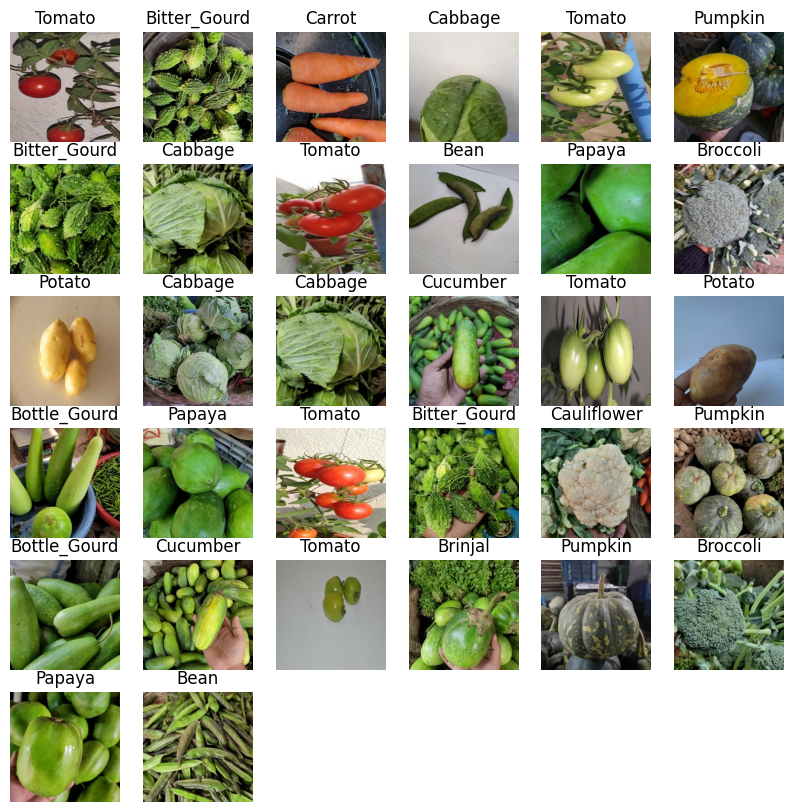

In [ ]:
# Show sample images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Define a function to convert an RGB image to grayscale
def rgb_to_grayscale(image, label):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

def rgb_to_grayscale2(img):
    img = tf.image.rgb_to_grayscale(img)
    return img

# Apply the grayscale conversion function to the dataset
# grayscale_train_dataset = X_train_aug.map(rgb_to_grayscale)
grayscale_validation_dataset = validation_dataset.map(rgb_to_grayscale)
grayscale_test_dataset = test_dataset.map(rgb_to_grayscale)

X_train_aug = rgb_to_grayscale2(X_train_aug)

In [ ]:
X_train_aug.shape

TensorShape([11770, 224, 224, 1])

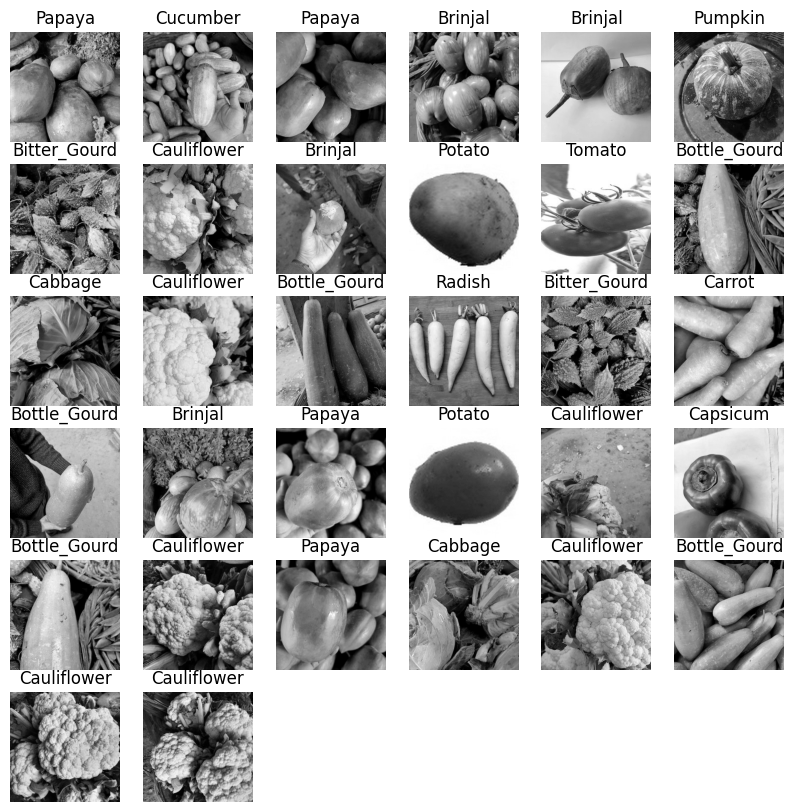

In [ ]:
import matplotlib.pyplot as plt
# Show greyscaled images
plt.figure(figsize=(10, 10))
for images, labels in grayscale_test_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Resize image into 31x31 images
NEW_IMG_SIZE = (128, 128)
AUTO = tf.data.AUTOTUNE

def preprocess_dataset(image, label):
    image = tf.image.resize(image, NEW_IMG_SIZE)
    label = label
    return (image, label)

# processed_train_dataset = (
#     grayscale_train_dataset
#     .map(preprocess_dataset, num_parallel_calls=AUTO)
# )

processed_validation_dataset = (
    grayscale_validation_dataset
    .map(preprocess_dataset, num_parallel_calls=AUTO)
)

processed_test_dataset = (
    grayscale_test_dataset
    .map(preprocess_dataset, num_parallel_calls=AUTO)
)

In [ ]:
def resize(img):
    img = tf.image.resize(img, NEW_IMG_SIZE)
    return img

X_train_aug = resize(X_train_aug)

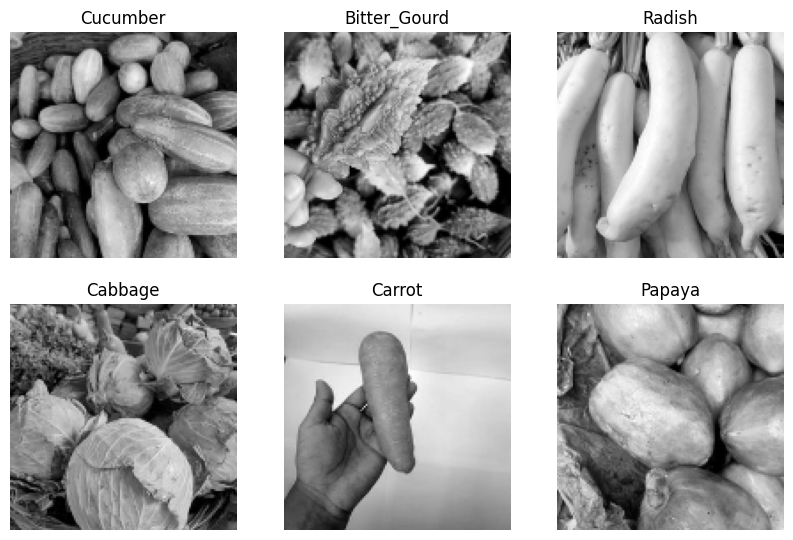

In [ ]:
# Show resized images
plt.figure(figsize=(10, 10))
for images, labels in processed_test_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def rescale(image, label):
    scale = tf.keras.layers.Rescaling(1./255)
    image = scale(image)
    label = label
    return image, label

def rescale2(img):
    scale = tf.keras.layers.Rescaling(1./255)
    img = scale(img)
    return img

X_train_aug = rescale2(X_train_aug)
processed_validation_dataset = processed_validation_dataset.map(rescale)
processed_test_dataset = processed_test_dataset.map(rescale)

## Model Improvements

In [ ]:
epochs = 30

Optimising batchsize

In [ ]:
# Run parametric experiment to tune dropout percentage
def createAndTrain_model_BatchSize(batchsize):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(128, 128, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(train_ds, 
                        validation_data=val_ds_128,
                        epochs=epochs,
                        batch_size=batchsize,
                        shuffle=True,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    # Evaluate model on unseen data
    scores = model.evaluate(test_ds_128)
    testError = 100-scores[1]*100

    return history, scores[1], testError

In [ ]:
# range of batch sizes
batchsizes = 2**np.arange(4, 9)

# initialize output results matrices
accuracyResultsTrain = np.zeros((epochs, len(batchsizes)))
accuracyResultsVal = np.zeros((epochs, len(batchsizes)))
accuracyResultsTest  = np.zeros((epochs, len(batchsizes)))

# loop over batch sizes
for bi in range(len(batchsizes)):
    history, score, testError = createAndTrain_model_BatchSize(batchsizes[bi])
    # store results
    accuracyResultsTrain[:,bi] = history.history['accuracy']
    accuracyResultsVal[:,bi] = history.history['val_accuracy']
    accuracyResultsTest[:,bi] = score

Epoch 1/50
736/736 [==============================] - 130s 176ms/step - loss: 2.2708 - accuracy: 0.3154 - val_loss: 6.3450 - val_accuracy: 0.1060
Epoch 2/50
736/736 [==============================] - 126s 171ms/step - loss: 1.4819 - accuracy: 0.5313 - val_loss: 4.4584 - val_accuracy: 0.3310
Epoch 3/50
736/736 [==============================] - 126s 171ms/step - loss: 0.9836 - accuracy: 0.6822 - val_loss: 6.4525 - val_accuracy: 0.3177
Epoch 4/50
736/736 [==============================] - 126s 171ms/step - loss: 0.6316 - accuracy: 0.7967 - val_loss: 1.5516 - val_accuracy: 0.6460
Epoch 5/50
736/736 [==============================] - 126s 171ms/step - loss: 0.4631 - accuracy: 0.8564 - val_loss: 7.7089 - val_accuracy: 0.3167
Epoch 6/50
736/736 [==============================] - 126s 172ms/step - loss: 0.3338 - accuracy: 0.8934 - val_loss: 6.9219 - val_accuracy: 0.3870
Epoch 7/50
736/736 [==============================] - 127s 172ms/step - loss: 0.2691 - accuracy: 0.9121 - val_loss: 2.1385 -

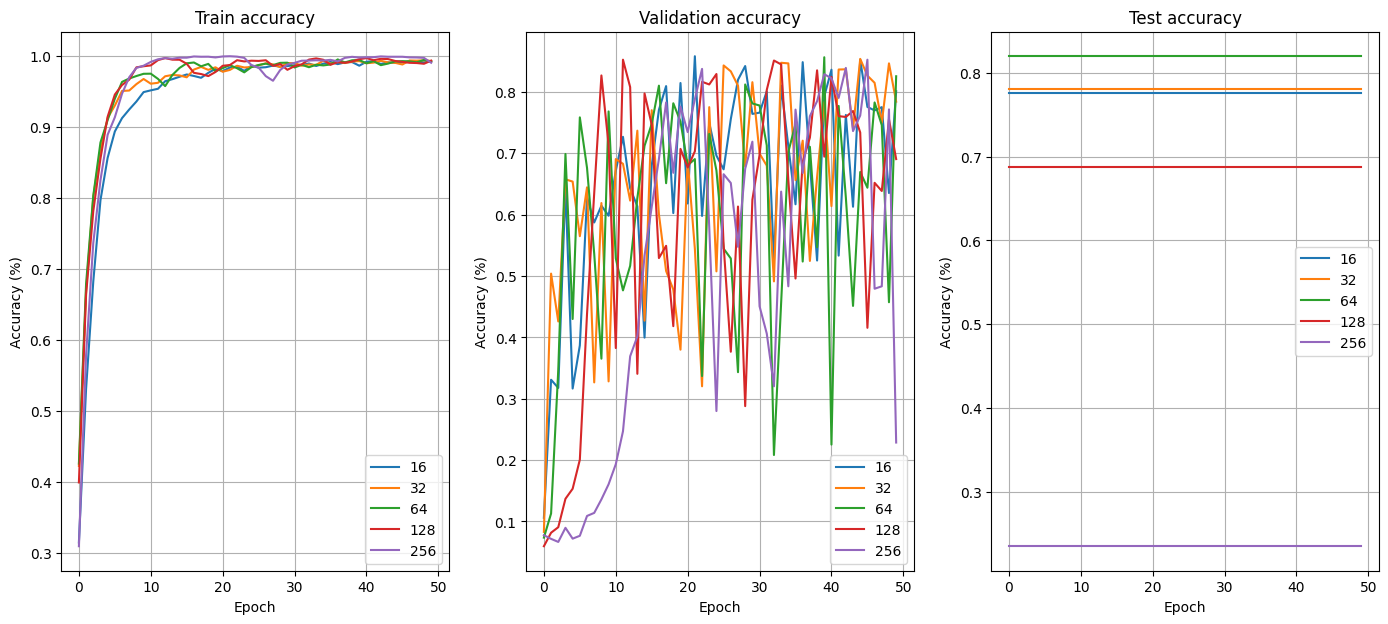

In [ ]:
# plot accuracy results
fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsVal)
ax[1].set_title('Validation accuracy')
ax[2].plot(accuracyResultsTest)
ax[2].set_title('Test accuracy')

# common features
for i in range(3):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].grid()

plt.show()

Tuning dropout

In [ ]:
# Run parametric experiment to tune dropout percentage
def createAndTrain_model_Dropout(dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(128, 128, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(train_ds, 
                        validation_data=val_ds_128,
                        epochs=30,
                        batch_size=64,
                        shuffle=True,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    # Evaluate model on unseen data
    scores = model.evaluate(test_ds_128)
    testError = 100-scores[1]*100

    return history, scores, testError

In [ ]:
# specify number of hidden units
dropout_percentages = np.arange(0, 1, 0.1)

# initialize results matrix
results = np.zeros((len(dropout_percentages),4))

for i,npercent in enumerate(dropout_percentages):
  history, scores, testError = createAndTrain_model_Dropout(int(npercent))
  results[i,:] = [ history.history['accuracy'][-1], history.history['val_accuracy'][-1], scores[1], testError ]


Epoch 1/30
184/184 [==============================] - 133s 719ms/step - loss: 2.0341 - accuracy: 0.4944 - val_loss: 18.6556 - val_accuracy: 0.1127
Epoch 2/30
184/184 [==============================] - 124s 673ms/step - loss: 0.7897 - accuracy: 0.7632 - val_loss: 26.2690 - val_accuracy: 0.0710
Epoch 3/30
184/184 [==============================] - 125s 682ms/step - loss: 0.3936 - accuracy: 0.8786 - val_loss: 7.6362 - val_accuracy: 0.2947
Epoch 4/30
184/184 [==============================] - 162s 879ms/step - loss: 0.1980 - accuracy: 0.9362 - val_loss: 8.4983 - val_accuracy: 0.2480
Epoch 5/30
184/184 [==============================] - 137s 745ms/step - loss: 0.0905 - accuracy: 0.9726 - val_loss: 1.5024 - val_accuracy: 0.6690
Epoch 6/30
184/184 [==============================] - 132s 717ms/step - loss: 0.0570 - accuracy: 0.9808 - val_loss: 2.5308 - val_accuracy: 0.6087
Epoch 7/30
184/184 [==============================] - 140s 761ms/step - loss: 0.0475 - accuracy: 0.9853 - val_loss: 5.8380

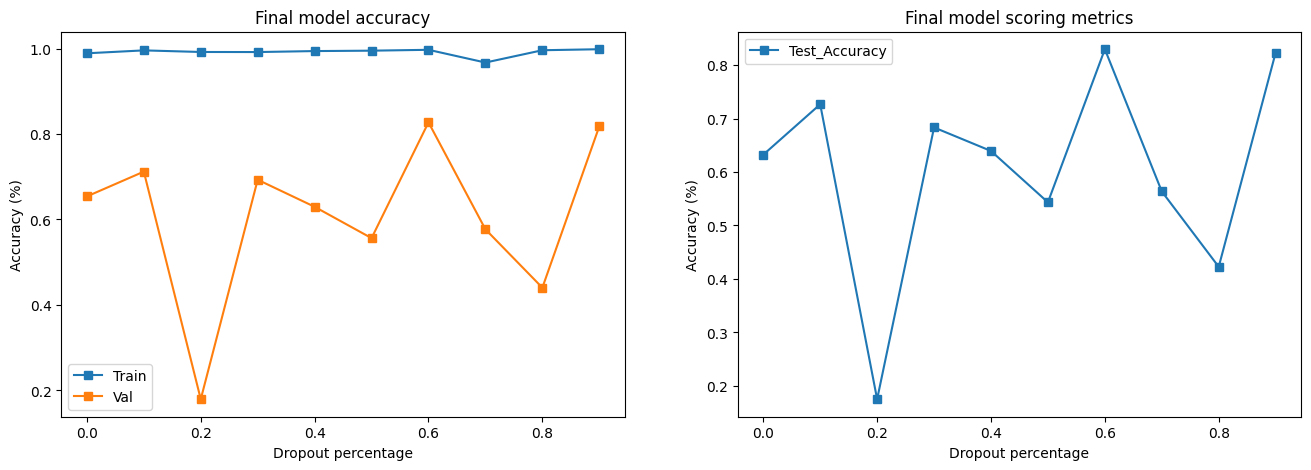

In [ ]:
# Plot parametric experiment results
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(dropout_percentages,results[:,:2],'s-')
ax[0].set_xlabel('Dropout percentage')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Final model accuracy')
ax[0].legend(['Train','Val'])

ax[1].plot(dropout_percentages,results[:,2],'s-')
ax[1].set_xlabel('Dropout percentage')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model scoring metrics')
ax[1].legend(['Test_Accuracy'])

plt.show()

Dropout of 0.3 seems to work best on the dataset

Tuning number of hidden units

In [ ]:
# Run parametric experiment to tune number of hidden units on Dense layer
def createAndTrain_model_NumUnits(numUnits):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(128, 128, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.6))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.6))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(numUnits, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(train_ds,
                        validation_data=val_ds_128,
                        epochs=30,
                        batch_size=64,
                        shuffle=True,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    # Evaluate model on unseen data
    scores = model.evaluate(test_ds_128)
    testError = 100-scores[1]*100

    return history, scores, testError

In [ ]:
# specify number of hidden units
numberOfLinearUnits = np.round(np.linspace(5,500,10))

# initialize results matrix
results = np.zeros((len(numberOfLinearUnits),4))

for i,nunits in enumerate(numberOfLinearUnits):
  history, scores, testError = createAndTrain_model_NumUnits(int(nunits))
  results[i,:] = [ history.history['accuracy'][-1], history.history['val_accuracy'][-1], scores[1], testError ]

Epoch 1/30
184/184 [==============================] - 117s 629ms/step - loss: 2.6802 - accuracy: 0.1130 - val_loss: 3.2475 - val_accuracy: 0.0820
Epoch 2/30
184/184 [==============================] - 116s 629ms/step - loss: 2.5518 - accuracy: 0.1658 - val_loss: 2.6662 - val_accuracy: 0.0947
Epoch 3/30
184/184 [==============================] - 111s 605ms/step - loss: 2.4866 - accuracy: 0.1811 - val_loss: 2.7265 - val_accuracy: 0.0770
Epoch 4/30
184/184 [==============================] - 111s 602ms/step - loss: 2.3786 - accuracy: 0.2184 - val_loss: 2.5922 - val_accuracy: 0.1190
Epoch 5/30
184/184 [==============================] - 118s 643ms/step - loss: 2.2839 - accuracy: 0.2524 - val_loss: 2.6565 - val_accuracy: 0.1270
Epoch 6/30
184/184 [==============================] - 113s 612ms/step - loss: 2.2177 - accuracy: 0.2702 - val_loss: 2.9072 - val_accuracy: 0.1303
Epoch 7/30
184/184 [==============================] - 110s 600ms/step - loss: 2.1730 - accuracy: 0.2844 - val_loss: 3.7774 -

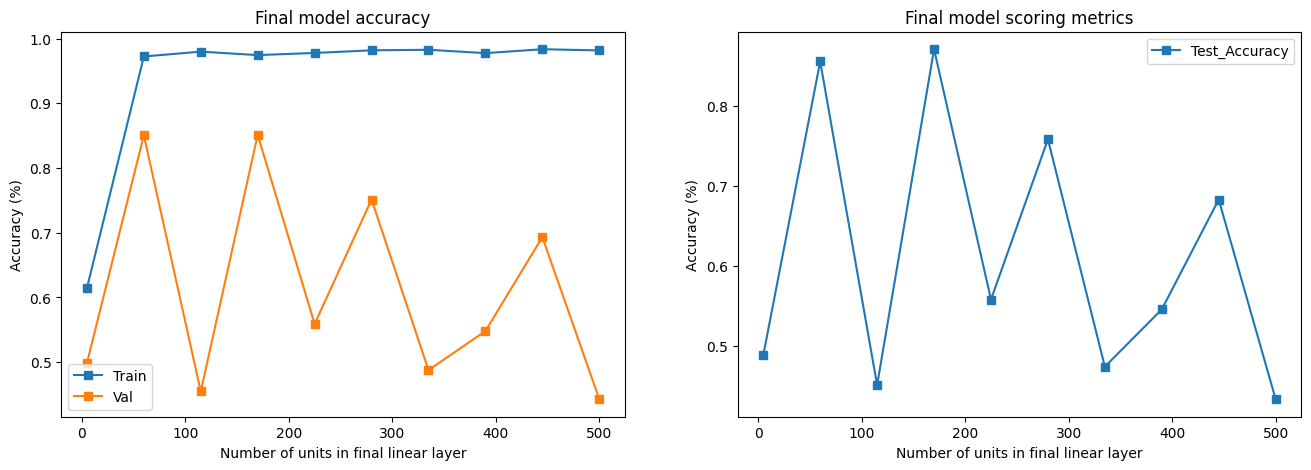

In [ ]:
# Plot parametric experiment results
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(numberOfLinearUnits,results[:,:2],'s-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Final model accuracy')
ax[0].legend(['Train','Val'])

ax[1].plot(numberOfLinearUnits,results[:,2],'s-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model scoring metrics')
ax[1].legend(['Test_Accuracy'])
# ax[1].set_ylim([0.87, 0.9])

plt.show()

Seems like 474 units in the hidden layer yields the greatest test accuracy (of around 87%), testing it out we get:

In [ ]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_128 = ModelCheckpoint('best_128_CNN.h5', save_best_only = True)

def make_finalModel():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(128, 128, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = make_finalModel()
history = model.fit(train_ds,
                    validation_data=val_ds_128, 
                    epochs=epochs,
                    batch_size=16,
                    shuffle=True,
                    callbacks=[monitor_val_acc, model_checkpoint_128])

# Evaluate model on unseen data
scores = model.evaluate(test_ds_128)
testError = 100-scores[1]*100
print(f'Model test accuracy on 128x128 images: {round(scores[1]*100,2)}%\nModel test error on 128x128 images: {round(testError,2)}%')

In [ ]:
model = make_finalModel()
model.load_weights('best_128_CNN.h5')
# Re-evaluate the model
loss, acc = model.evaluate(test_ds_128, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# plot first few filters
n_filters, ix = 2, 1
plt.suptitle(f'Feature map examples from convolution layers')
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Kernel {j+1}, Conv {i+1}')
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
    # show the figure
    plt.show()